# Baryonic halo model 

In this example, we illustrate how to build a baryonic halo model in CCL. We follow mostly the equations in Fedeli (2014), arXiv:1401.2997, with some small modifications.

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
from scipy.special import erf
from scipy import integrate
from scipy import interpolate
from functools import partial
%matplotlib inline

## Preliminaries

Generate a cosmology and a vector with wavenumbers. We will work only at $z=0$ for this example.

In [2]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.196, Omega_b=0.042, h=0.73, sigma8=0.74, n_s=0.951)

# Wavenumbers 
k_arr = np.geomspace(1E-2,1E2,256)

# Scale factor
a_sf=1

Let us also initialize a series of halo model quantities. We will need:

- A halo mass definition.
- A concentration-mass relation.
- A halo mass function parametrization.
- A halo bias parametrization.
- Halo density profiles (for the dark matter part of the model).

In [3]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# halo mass function
hmf_200m = ccl.halos.MassFuncTinker10(cosmo, mass_def=hmd_200m)

# The Tinker 2010 halo bias
hbf = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# The NFW profile - this is for dark matter only
pM = ccl.halos.profiles.HaloProfileNFW(cM)

The baryonic halo model consists of three ingredients: gas, stars and dark matter. The contribution of each ingredient is weighted by their energy density at $z=0$, which are given by

In [4]:
# Define some useful densities
rho_star = 7E8*cosmo['h']**2
rho_m = cosmo['Omega_m']*ccl.physical_constants.RHO_CRITICAL*cosmo['h']**2
rho_DM = cosmo['Omega_c']*ccl.physical_constants.RHO_CRITICAL*cosmo['h']**2
rho_g = rho_m - rho_star - rho_DM

We are now going to define some useful constants that we will need later.

In [5]:
#For the stellar mass fraction within halos
m_0s = 5E12/cosmo['h']
sigmas = 1.2

#For the stellar profile
x_deltas = 1/0.03

#For the gas mass fraction within halos
m_0g = 10E12/cosmo['h']
sigmag = 3

#For the gas profile
beta = 2.9

#Parameters that inform the power spectrum of the gas,
#specifically the extended component.
Fg = 0.05 #this is an example, it should be <<1
bd = 0.85 #from Fedeli

# A reference halo mass that will be used later
mhalo = 1E14/cosmo['h']

To compute halo model ingredients of the power spectrum, we will need to integrate over the masses of the contributing halos. These will be slightly different for stars, DM and gas. Here we define them:

In [6]:
# Array of masses
mmin_DM=1E6
mmax_DM=1E16
mmin_gas=m_0g
mmax_gas=mmax_DM
mmin_stars=1E10
mmax_stars=1E15
m_arr = np.geomspace(mmin_DM,mmax_DM,128)

## Stellar component

First we will compute the stellar mass fraction.

$f_*(m)=A\exp(-\frac{\log_{10}^2(m/m_{0s})}{2\sigma_s^2})$

We fix $A$ by requiring that $\bar{\rho}_*$ have a particular value.

$\bar{\rho}_*=\int_0^∞dmmf_*(m)n(m)$

where $n(m)$ is the halo mass function.

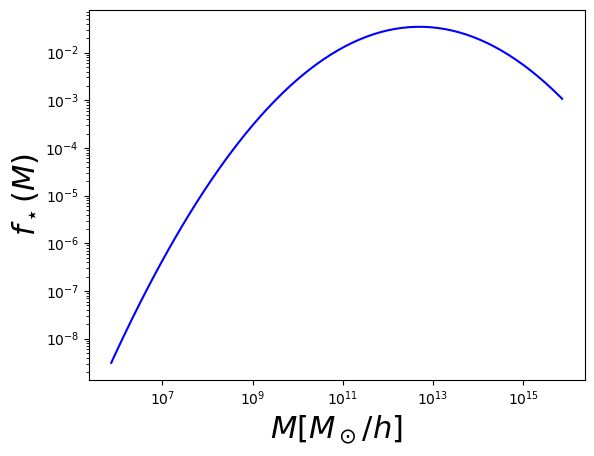

In [7]:
#This computes the normalization of the stellar mass fraction
def f_star_integrand(m):
    mf = hmf_200m.get_mass_function(cosmo,m,a_sf)/(m*np.log(10))
    return m*np.exp(-(np.log10(m/m_0s))**2/(2*sigmas**2))*mf
def f_star_norm():
    #return integrate.romberg(f_star_integrand,mmin_stars,mmax_stars,tol=0,rtol=1E-3,divmax=5000)
    return integrate.quad(f_star_integrand,mmin_stars,mmax_stars,epsabs=0,epsrel=1E-3,limit=5000)[0]

#Stellar mass fraction
A = rho_star/f_star_norm()
def f_star(m):
    return A*np.exp(-(np.log10(m/m_0s))**2/(2*sigmas**2))

plt.figure()
plt.plot(m_arr*cosmo['h'], f_star(m_arr), 'b-')
plt.xlabel(r'$M [M_\odot/h]$',fontsize=22)
plt.ylabel(r'$f_\star(M)$',fontsize=22)
plt.xscale('log')
plt.yscale('log')
plt.show()

Next, we define the shape of the stellar profiles and we make a class out of them, so we can then pass them on to the power spectrum method. 

$\rho_*(x|m)=\frac{\rho_t}{x}\exp(-x^\alpha)$, with $x:=r/r_t$.

An additional constraint on $\rho_t$ comes from requiring that the mass fraction overall is equal to the mass fraction within a halo.

In [8]:
#Stellar profile
class HaloProfileStars(ccl.halos.HaloProfile):
    def __init__(self):
        super(HaloProfileStars, self).__init__()

    #scale radius
    def _rs(self, cosmo, M, a, mdef):
        return mdef.get_radius(cosmo, M, a) / a #@Una: Rdelta (comoving, check?)

    def _real(self, cosmo, r, M, a, hmd_200m):
        # Generate 2D array by default
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        # Compute profile
        r_delta = self._rs(cosmo, M_use, a, hmd_200m)
        r_t = r_delta/x_deltas
        x = r_use/r_t[:, None]
        rhot = M_use*f_star(M_use)/(4* np.pi * r_t**3)
        prof = rhot[:,None] * np.exp(-x)/x   

        # Make sure the output has the right shape
        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

ps = HaloProfileStars()
ps.update_precision_fftlog(padding_hi_fftlog=1E3,
                           padding_lo_fftlog=1E-3,
                           n_per_decade=1000,
                           plaw_fourier=-2.)

## Gas component

We now turn to the gas, again defining the gas fraction in each halo approximately as:

$f_g(m)=\frac{\Omega_b}{\Omega_m}\text{erf}\left[\frac{\log_{10}(m/m_{0g})}{\sigma_g}\right]$

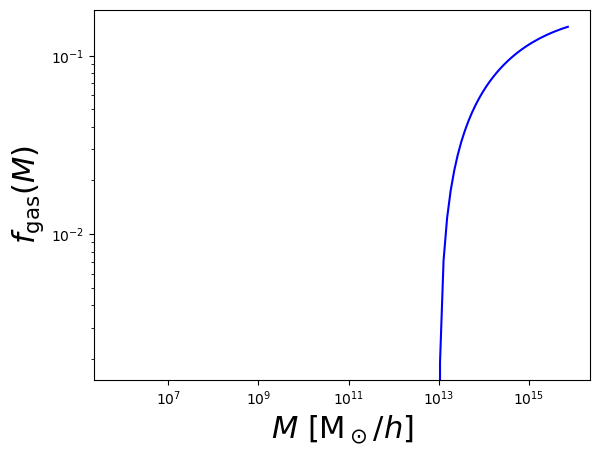

In [9]:
def f_gas(m):
    fgas = []
    for i in m:
        if i<m_0g:
            fgas.append(0.)
        else:
            fgas.append((cosmo['Omega_b']/cosmo['Omega_m'])*erf(np.log10(i/m_0g)/sigmag))
    return fgas

plt.figure()
plt.plot(m_arr*cosmo['h'],f_gas(m_arr), 'b-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M$ $[$M$_\odot/h]$',fontsize=22)
plt.ylabel(r'$f_{\rm gas}(M)$',fontsize=22)
plt.show()

We now define a class that describes the profiles for the bound gas. Note we use a slightly different gas profile to Fedeli (2014):

$\rho_g(r)=\frac{\rho_{g,0}}{(1+u)^\beta(1+v^2)^{(7-\beta)/2}}$, with $u:=r/r_{co}$ and $v:=r/r_{ej}$.

In [10]:
class HaloProfileGas(ccl.halos.HaloProfile):
    def __init__(self):
        super(HaloProfileGas, self).__init__()

    #scale radius
    def _rs(self, cosmo, M, a, mdef):
        return mdef.get_radius(cosmo, M, a) / a 

    def _rint(self, M, Rd, r):
        r_co = 0.1*Rd
        r_ej = 1.1*Rd #just placeholder value
        return r**2/((1+r/r_co)**beta*(1+(r/r_ej)**2)**((7-beta)/2))

    def _norm(self,M,Rd):
        nn = f_gas(M)*M/(4*np.pi*np.array([integrate.romberg(partial(self._rint, mm, rd),
                                                             1E-3,50,tol=0,rtol=1E-1,divmax=5000)
                                           for mm, rd in zip(M, Rd)]))
        return nn

    def _real(self, cosmo, r, M, a, mdef):
        # Generate 2D array by default
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        # Compute profile
        r_delta = self._rs(cosmo, M_use, a, mdef)
        r_co = 0.1*r_delta
        r_ej = 1.1*r_delta

        prof = 1/((1+r_use[None,:]/r_co[:,None])**beta*(1+(r_use[None,:]/r_ej[:,None])**2)**((7-beta)/2))
        norm = self._norm(M_use,r_delta)
        prof = prof[:,:]*norm[:,None]

        # Make sure the output has the right shape
        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

pg = HaloProfileGas()
pg.update_precision_fftlog(padding_hi_fftlog=1E3,padding_lo_fftlog=1E-3,
                           n_per_decade=1000,plaw_fourier=-2.)

## Interpolation of profiles

It takes a while to evaluate the profiles. For this reason, we are going to interpolate them so we can use them later.

In [11]:
#Interpolate the profiles for speed

M = np.logspace(np.log10(mmin_DM),np.log10(mmax_DM),num=20)
yDM=np.zeros((20,500))
M2D = np.zeros((20,500))
for i in range(0,500):
    M2D[:,i]=M
K = np.linspace(1E-2,1E2,num=500)
for j in range(0,20):
    yDM[j,:]=pM.fourier(cosmo, K,M[j], a_sf, hmd_200m)/M[j]
fDM = interpolate.interp2d(K, M, yDM)

print("DM profiles interpolated...\n")

M = np.logspace(np.log10(mmin_gas),np.log10(mmax_gas),num=10)
yg=np.zeros((10,500))
M2D = np.zeros((10,500))
for i in range(0,500):
    M2D[:,i]=M
K = np.linspace(1E-2,1E2,num=500)
for j in range(0,10):
    yg[j,:]=pg.fourier(cosmo, K,M[j], a_sf, hmd_200m)/M[j]
f = interpolate.interp2d(K, M, yg)

print("Gas profiles interpolated...\n")

M = np.logspace(np.log10(mmin_stars),np.log10(mmax_stars),num=10)
M2D = np.zeros((len(M),50))
for i in range(0,50):
    M2D[:,i]=M
K = np.linspace(1E-2,1E2,num=50)
ys=ps.fourier(cosmo, K,M, a_sf, hmd_200m)/M2D
fs = interpolate.interp2d(K,M,ys)

print("Star profiles interpolated...\n")

DM profiles interpolated...

Gas profiles interpolated...

Star profiles interpolated...



## Calculation of power spectra

We define some generic integrals that are needed for the one halo and two halo power spectra of the different components of the model:

$I_{2p}=\int_0^\infty dm n(m) m^2y_1(k)y_2(k)$

$I_{bp}=\int_0^\infty dm n(m) b(m) my(k)$

In [12]:
# Halo Mass Calculator (for DM)
hmc = ccl.halos.HMCalculator(cosmo, hmf_200m, hbf, hmd_200m)

# Non-linear matter power spectrum, for comparison
pk_nl = ccl.nonlin_matter_power(cosmo, k_arr, a_sf)

#Generic integrals we need
#(of the form 5.x in Fedeli (2014))
def integrandGEN2p(m,k,prof1,prof2):
    dndlog10m = hmf_200m.get_mass_function(cosmo, m, a_sf)
    dndm=dndlog10m/(m*np.log(10.))
    y1=prof1(k,m)
    y2 =prof2(k,m)
    return dndm*m**2*y1*y2
def integratedGEN2p(mmin,mmax,k,p1,p2):
    return integrate.quad(integrandGEN2p, mmin, mmax, args=(k,p1,p2),epsabs=0,epsrel=1E-3,limit=5000)[0]
def integrandGENbp(m,k,prof1):
    bm = hbf.get_halo_bias(cosmo,m,a_sf)
    dndlog10m = hmf_200m.get_mass_function(cosmo, m, a_sf)
    dndm=dndlog10m/(m*np.log(10.))
    y=prof1(k,m)
    return dndm*m*bm*y
def integratedGENbp(mmin,mmax,k,p1):
    return integrate.quad(integrandGENbp, mmin, mmax, args=(k,p1),epsabs=0,epsrel=1E-3,limit=5000)[0]

We start with the dark matter:

In [13]:
#Dark matter auto-spectra

def PDM2h(k):
    return ccl.linear_matter_power(cosmo, k, a_sf)/rho_DM**2*integratedGENbp(mmin_DM,mmax_DM,k,fDM)**2

def PDM1h(k):
    return 1/rho_DM**2*integratedGEN2p(mmin_DM,mmax_DM,k,fDM,fDM)

PDM1h_arr=np.zeros(len(k_arr))
PDM2h_arr=np.zeros(len(k_arr))
for i in range(0,len(k_arr)):
    PDM1h_arr[i]=PDM1h(k_arr[i])
    PDM2h_arr[i]=PDM2h(k_arr[i])

Then the gas:

In [14]:
#Gas auto-spectra

def PG2h(k):
    return ccl.linear_matter_power(cosmo, k, a_sf)/(Fg*rho_g)**2*integratedGENbp(mmin_gas,mmax_gas,k,f)**2

def PG1h(k):
    return 1/(Fg*rho_g)**2*integratedGEN2p(mmin_gas,mmax_gas,k,f,f)

def PGd(k):
    return bd**2*ccl.linear_matter_power(cosmo, k, a_sf)

def PGdh(k):
    return bd*ccl.linear_matter_power(cosmo, k, a_sf)/(Fg*rho_g)*integratedGENbp(mmin_gas,mmax_gas,k,f)

PG2h_arr=np.zeros(len(k_arr))
PG1h_arr=np.zeros(len(k_arr))
PGd_arr=np.zeros(len(k_arr))
PGdh_arr=np.zeros(len(k_arr))
for i in range(0,len(k_arr)):
    PG2h_arr[i]=PG2h(k_arr[i])
    PGd_arr[i]=PGd(k_arr[i])
    PG1h_arr[i]=PG1h(k_arr[i])
    PGdh_arr[i]=PGdh(k_arr[i])

PG = Fg**2*(PG2h_arr + PG1h_arr) + (1-Fg)**2*PGd_arr + 2*Fg*(1-Fg)*PGdh_arr

And their cross-correlation:

In [16]:
#DM x gas

def PDMgdh(k):
    return (bd*ccl.linear_matter_power(cosmo, k, a_sf)/rho_DM)*integratedGENbp(mmin_DM,mmax_DM,k,fDM)
def PDMg1h(k):
    return 1/(rho_DM*Fg*rho_g)*integratedGEN2p(mmin_gas,mmax_gas,k,f,fDM)
def PDMg2h(k):
    return ccl.linear_matter_power(cosmo, k, a_sf)/(rho_DM*Fg*rho_g)*integratedGENbp(mmin_DM,mmax_DM,k,fDM)*integratedGENbp(mmin_gas,mmax_gas,k,f)

PDMgdh_arr=np.zeros(len(k_arr))
PDMg2h_arr=np.zeros(len(k_arr))
PDMg1h_arr=np.zeros(len(k_arr))
for i in range(0,len(k_arr)):
    PDMgdh_arr[i]=PDMgdh(k_arr[i])
    PDMg1h_arr[i]=PDMg1h(k_arr[i])
    PDMg2h_arr[i]=PDMg2h(k_arr[i])

PDMg = (1-Fg)*PDMgdh_arr + Fg*(PDMg1h_arr+PDMg2h_arr)

We will now compute all spectra that involve a stellar contribution:

In [17]:
#Stars auto spectrum
def PS2h(k):
    return ccl.linear_matter_power(cosmo, k, a_sf)/rho_star**2*integratedGENbp(mmin_stars,mmax_stars,k,fs)**2

def PS1h(k):
    return 1/rho_star**2*integratedGEN2p(mmin_stars,mmax_stars,k,fs,fs)

PS2h_arr=np.zeros(len(k_arr))
PS1h_arr=np.zeros(len(k_arr))
for i in range(0,len(k_arr)):
    PS2h_arr[i]=PS2h(k_arr[i])
    PS1h_arr[i]=PS1h(k_arr[i])

In [18]:
#DM x stars

def PDMs1h(k):
    return 1/(rho_DM*rho_star)*integratedGEN2p(mmin_stars,mmax_stars,k,fDM,fs)

def PDMs2h(k):
    ii=integratedGENbp(mmin_stars,mmax_stars,k,fs)*integratedGENbp(mmin_DM,mmax_DM,k,fDM)
    return ccl.linear_matter_power(cosmo, k, a_sf)/(rho_DM*rho_star)*ii

#Eval and add DM x stars
PDMs1h_arr=np.zeros(len(k_arr))
PDMs2h_arr=np.zeros(len(k_arr))
for i in range(0,len(k_arr)):
    PDMs1h_arr[i]=PDMs1h(k_arr[i])
    PDMs2h_arr[i]=PDMs2h(k_arr[i])
PDMs = PDMs1h_arr+PDMs2h_arr

In [19]:
#Stars x gas
def Psgh(k):
    return bd*ccl.linear_matter_power(cosmo, k, a_sf)/rho_star*integratedGENbp(mmin_stars,mmax_stars,k,fs)

def Psg1h(k):
    return 1/(rho_star*Fg*rho_g)*integratedGEN2p(mmin_gas,mmax_stars,k,f,fs)

def Psg2h(k):
    ii=integratedGENbp(mmin_stars,mmax_stars,k,fs)*integratedGENbp(mmin_gas,mmax_gas,k,f)
    return ccl.linear_matter_power(cosmo, k, a_sf)/(rho_star*Fg*rho_g)*ii

#Eval and add star x gas
Psgh_arr=np.zeros(len(k_arr))
Psg2h_arr=np.zeros(len(k_arr))
Psg1h_arr=np.zeros(len(k_arr))
for i in range(0,len(k_arr)):
    Psgh_arr[i]=Psgh(k_arr[i])
    Psg1h_arr[i]=Psg1h(k_arr[i])
    Psg2h_arr[i]=Psg2h(k_arr[i])
Psg = (1-Fg)*Psgh_arr + Fg*(Psg1h_arr+Psg2h_arr)

Now plot them all and add them to form the total. We will plot them relative to the standard nonlinear matter power spectrum from CCL, which does not account for baryons.

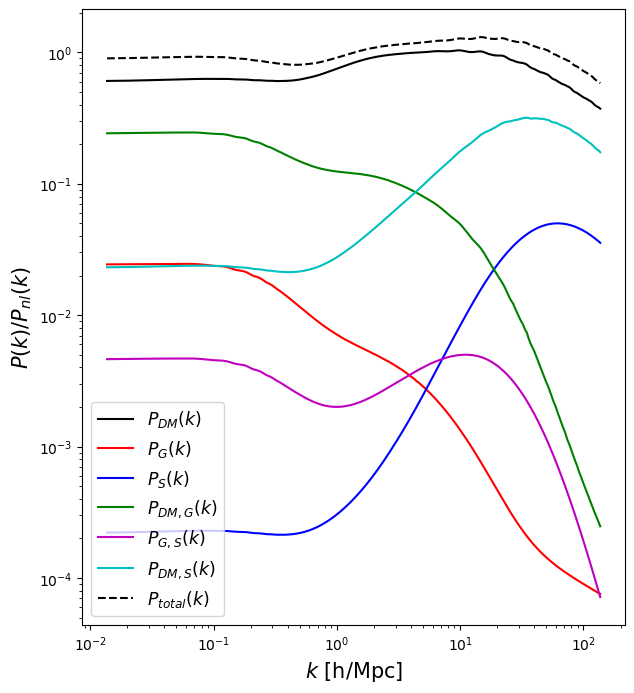

In [21]:
#Auto-spectra
Pauto = (rho_DM/rho_m)**2*(PDM2h_arr+PDM1h_arr)+(rho_g/rho_m)**2*PG+(rho_star/rho_m)**2*(PS1h_arr+PS2h_arr)
#Cross-spectra
Pcross = (2*rho_DM*rho_star*PDMs +2*rho_g*rho_star*Psg+2*rho_DM*rho_g*PDMg)/(rho_m**2)
#Add all
Ptotal = Pauto + Pcross

#Relative power spectra
plt.figure(figsize=(7,8))
#All auto correl
plt.plot(k_arr/cosmo['h'], (rho_DM/rho_m)**2*(PDM2h_arr+PDM1h_arr)/pk_nl, 'k-', label='$P_{DM}(k)$')
plt.plot(k_arr/cosmo['h'], (rho_g/rho_m)**2*PG/pk_nl, 'r-', label='$P_{G}(k)$')
plt.plot(k_arr/cosmo['h'], (rho_star/rho_m)**2*(PS2h_arr+PS1h_arr)/pk_nl, 'b-', label='$P_{S}(k)$')
#All cross correl
plt.plot(k_arr/cosmo['h'], 2*rho_DM*rho_g/(rho_m**2)*PDMg/pk_nl, 'g-', label='$P_{DM,G}(k)$')
plt.plot(k_arr/cosmo['h'], 2*rho_g*rho_star/(rho_m**2)*Psg/pk_nl, 'm-', label='$P_{G,S}(k)$')
plt.plot(k_arr/cosmo['h'], 2*rho_DM*rho_star/(rho_m**2)*PDMs/pk_nl, 'c-', label='$P_{DM,S}(k)$')
#And the total with respect to CAMBs nonlinear power
plt.plot(k_arr/cosmo['h'], Ptotal/pk_nl, 'k--', label='$P_{total}(k)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=12.5)
plt.ylabel(r'$P(k)/P_{nl}(k)$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm h/Mpc}]$', fontsize=15)
plt.show()
